<a href="https://colab.research.google.com/github/suy379/do_it_DL_intro/blob/main/05_%ED%9B%88%EB%A0%A8_%EB%85%B8%ED%95%98%EC%9A%B0_4%EA%B0%80%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. 훈련 노하우 배우기
- 05-1. 검증셋 나누기 & 전처리
- 05-2. 과대적합과 과소적합
- 05-3. 규제 방법을 배우고 단일층 신경망에 적용하기
- 05-4. 교차검증을 알아보고 사이킷런으로 수행하기


## 05-1. 검증셋 나누기 & 전처리
### 검증셋 나누기

In [ ]:
#데이터를 훈련셋, 테스트셋으로 나누기
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

In [ ]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
#4장에서 한 사이킷런의 SGDClassifier 모델 적용
from sklearn.linear_model import SGDClassifier
#객체
sgd = SGDClassifier(loss='log', random_state=42) #로지스틱 회귀 모델
#학습
sgd.fit(x_train_all, y_train_all)
#평가
sgd.score(x_test, y_test)

0.8333333333333334

- 하이퍼파라미터 값을 바꿔 성능 향상시키기

In [ ]:
#loss를 log(로지스틱 모델) 말고 hinge(선형 서포트 벡터 머신:SVM)으로 바꿔보자.
#객체
sgd = SGDClassifier(loss='hinge', random_state=42) #SVM 모델 
#학습
sgd.fit(x_train_all, y_train_all)
#평가
sgd.score(x_test, y_test) #성능이 좀 더 향상되었다! 

0.9385964912280702

- 하지만 우리가 모델링을 할 때는 이렇게 데이터를 train/test로만 나누면 안된다.
- 반드시 __성능 평가를 할 수 있는 validation set__이 있어야 함!
- 보통 train set을 train/val 8:2로 나누고
- 만일 데이터가 1개 종류뿐이라면 train/val/test를 8:2:2로 나눔.

In [ ]:
#데이터 준비
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
#전체 데이터를 우선 8:2 비율로 나눔
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
#train set에 대해 8:2로 train/val로 나눔
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train),len(x_val))

364 91


In [ ]:
#앞에서 훈련시킨 것 다시 실행
#4장에서 한 사이킷런의 SGDClassifier 모델 적용
from sklearn.linear_model import SGDClassifier
#객체
sgd = SGDClassifier(loss='log', random_state=42) #로지스틱 회귀 모델
#학습
sgd.fit(x_train, y_train)
#평가
sgd.score(x_val, y_val) 

0.6923076923076923

- 결과를 보면 이전에 비해 결과가 더 떨어졌다!!ㅜㅜ
- 그 이유는 __훈련 데이터(train set)의 수가 이전보다 더 적어졌기 때문.__
- 이렇게 train set이 적다면 튜닝 시 k-fold cv(교차검증)을 사용하고, 데이터의 수가 10만개 이상으로 크다면 최대한 train set에 많은 데이터를 할당해야 한다.

### 데이터 전처리
- 이 책에서 사용하는 모든 신경망 알고리즘은 경사 하강법을 기반으로 함. 경사하강법은 스케일에 민감하므로 __피처 간 스케일 조정이 반드시 필요!__

In [ ]:
print(cancer.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [ ]:
#만일 스케일을 조정하지 않는다면, 얼마나 모델 성능에 차이가 있는지 알아보자.
#cancer 데이터의 2,3번 피처 둘은 스케일이 다르다.
print(cancer.feature_names[[2,3]])

['mean perimeter' 'mean area']


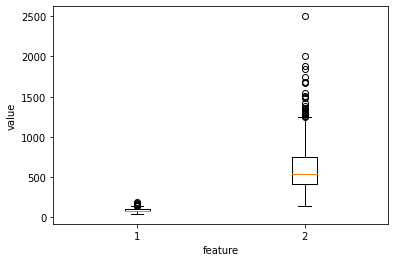

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(x_train[:, 2:4]) #인덱스가 2,3번 피처
plt.xlabel('feature')
plt.ylabel('value')
plt.show() #x축의 1,2는 그냥 plot 출력하면 붙여지는 이름이라 신경 no

- 경사 하강법 클래스(SingleLayer)에 __에포크별 가중치의 값__을 저장할 변수(self.w_history)를 추가하여 가중치 변화가 어떤지 살펴보자.
- 또한 학습률의 개념(self.lr)도 추가한다.
- 클래스 수정 후 스케일링 안한 버전으로 돌려보고, 스케일링 한 버전으로 돌려본 후 2개를 비교해보자.

In [ ]:
import numpy as np
class SingleLayer:

    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.w_history= [] #에포크별 가중치의 값을 추가.
        self.lr = learning_rate 
    
    # 정방향 계산 메서드(z를 출력)
    def forpass(self, x):
        z = np.sum(x*self.w) + self.b 
        return z

    # 정방향 메서드(a를 출력)
    def activation(self, z):
        a = 1 / (1+np.exp(-z))
        return a 

    # 역방향 계산(그레디언트를 출력)
    def backprop(self, x, err):
        w_grad = x*err
        b_grad = 1*err
        return w_grad, b_grad 

    # 핵심: 학습 메서드 --> 이 안엔 train셋(x_train, y_train)만 넣기.
    def fit(self, x, y, epochs=100):
        #초기값 설정
        self.w = np.ones(x.shape[1]) 
        self.b = 0
        self.w_history.append(self.w.copy()) #값 초기화 
        np.random.seed(42) #실습 결과 동일함을 위해 설정 
        #epochs만큼 반복
        for i in range(epochs):
            loss = 0 #loss 값 초기화 
            indexes = np.random.permutation(np.arange(len(x))) #index 값 섞기
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z) 
                err = -(y[i]-a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= w_grad*self.lr
                self.b -= b_grad
                #가중치 기록
                self.w_history.append(self.w.copy())
                #각 샘플에 대해 index마다 loss를 계산
                a = np.clip(a, 1e-10, 1-1e-10) 
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a)) 
            self.losses.append(loss/len(y)) 

    # 핵심: 예측 메서드-- 이 안에는 x_test만 넣는다.
    def predict(self, x):
        z = [self.forpass(xi) for xi in x] 
        return np.array(z) >0 
    
    # 평가 메서드-- 이 안에는 앞서 predict로 반환된 값과 y_test를 비교한 정확도를 출력.
    def score(self, x, y):
        return np.mean(self.predict(x) == y)


In [ ]:
#객체
layer1 = SingleLayer() #learning_rate는 0.1 기본값 사용 
#학습
layer1.fit(x_train, y_train)
#평가
layer1.score(x_val, y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


0.9120879120879121

In [ ]:
#layer1.w_history 값을 반환(리스트)하여 시각화 - 가중치 변화가 어떤지?
print(len(x_train))
print(len(layer1.w_history)) #개별 데이터(364개)*epoch수(100번)+초깃값 1개 
print(layer1.w_history[:20]) #피처가 30개라서 한 w값 당 30개의 피처별 가중치가 들어있음.(처음엔 1로 모두 초기화되었다가 그 다음부터 바뀌어 있음)
                                            #초반에 계속 값이 1인 것은 값차이가 얼마 나지 않아서임

364
36401
[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1.

In [ ]:
#변화를 보려면 w_history에서 2,3번째 피처의 가중치 값만 뽑아야 함! 
layer1.w_history[20] #예를 들어 20번째 값에 30개 가중치 중 2,3번째 값만 얻고자 함.
 #--> 그렇게 하려면 w_history라는 리스트 값에서 하나씩 array를 빼고(이 array 하나엔 가중치 30개들 있음) 그 array에서 2, 3번째 값만 뽑아야 함.

array([  2.264    ,   3.493    ,   8.553    , -11.07     ,   1.014855 ,
         0.997379 ,   0.983535 ,   0.990719 ,   1.03142  ,   1.012436 ,
         0.98872  ,   1.42163  ,   0.7785   ,  -5.275    ,   1.0004103,
         0.9983726,   0.9953266,   0.9978259,   1.004901 ,   1.000083 ,
         2.2138   ,   3.404    ,   7.533    , -32.16     ,   1.017387 ,
         0.981639 ,   0.958475 ,   0.984079 ,   1.04389  ,   1.011417 ])

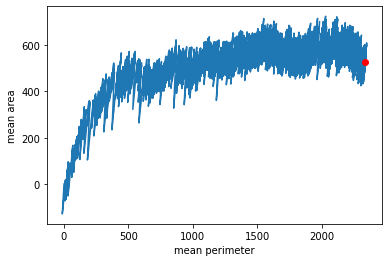

In [ ]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2,w3)
plt.plot(w2[-1], w3[-1], 'ro') #'ro'는 red로 o표시라는 뜻으로, 최종으로 결정된 가중치를 뜻함.
plt.xlabel('mean perimeter') #w2
plt.ylabel('mean area') #w3
plt.show() #결과를 보면 w2에 비해 w3의 스케일이 더 컸으므로(아까 boxplot에서) w3값이 학습과정에서 큰 폭으로 흔들리며 변화하고 있음. 그에비해, w2는 0부터 안정적으로 커짐.
              #즉, w3에 대한 그레이디언트가 크기 때문에 w3축을 따라 가중치가 크게 요동치고 있다.-->그러므로 스케일이 컸던 w3는 조정 필요!

#### Scaling - 표준화
- 주의: 스케일링은 피처들(X값)에 대해서만 수행한다.
- 훈련셋에 먼저해주고, 그 후 검증셋에 대해서도 스케일링해야 한다.__(단, 검증셋 스케일링 시 훈련셋의 mean, std값을 갖고 스케일링할 것!!)__
- 마찬가지로 금고에 보관된 test set에 대해 예측 시에도 훈련셋의 정보로 스케일링 후 예측하자.

In [ ]:
#넘파이로 표준화 구현하기 
## axis=0는 행 기준이나, 연산을 하면 열별 값(피처별 값)을 반환한다.
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
print(train_mean) #피처별 평균값(30개)

[1.40436566e+01 1.91348901e+01 9.15087912e+01 6.46860714e+02
 9.66672802e-02 1.06530879e-01 9.25500687e-02 4.94793104e-02
 1.81235440e-01 6.32180495e-02 3.98745879e-01 1.19554121e+00
 2.84499560e+00 3.94911291e+01 7.06729945e-03 2.63674258e-02
 3.38595107e-02 1.19517390e-02 2.10207033e-02 3.88186566e-03
 1.61716703e+01 2.54807143e+01 1.06804066e+02 8.70164835e+02
 1.32761923e-01 2.61024258e-01 2.84094860e-01 1.15873299e-01
 2.92375275e-01 8.46321978e-02]


In [ ]:
#표준화
x_train_scaled = (x_train - train_mean)/train_std 

In [ ]:
#모델 훈련 다시
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)

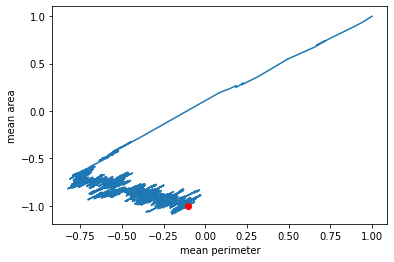

In [ ]:
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2,w3)
plt.plot(w2[-1], w3[-1], 'ro') #'ro'는 red로 o표시라는 뜻으로, 최종으로 결정된 가중치를 뜻함.
plt.xlabel('mean perimeter') #w2
plt.ylabel('mean area') #w3
plt.show() 
#w2와 w3 간 변화비율이 비슷하므로 대각선 방향으로 가중치가 이동하였으며, 최적값(빨강점)에 빠르게 근접함.
#처음보다 w2에 비해 w3의 값이 크게 증가하지 않음. 둘다 비슷함!! 

In [ ]:
#평가 결과는?
layer2.score(x_val, y_val) #당연히 안좋게 나온다. 스케일링시킨 train셋으로 훈련했으니 val도 그래야함!

0.37362637362637363

In [ ]:
#검증셋 스케일링
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean)/val_std

layer2.score(x_val_scaled, y_val)

0.967032967032967

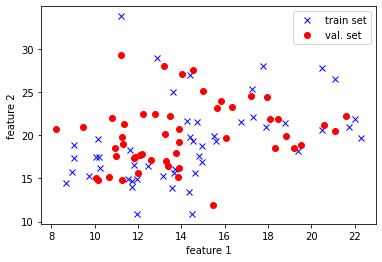

In [ ]:
## 실수하기 쉬운 함정들

#원본 훈련셋, 검증셋으로 산점도 그리기(파랑: 훈련셋, 빨강: 검증셋) - 데이터 50개씩만 뽑아서 나타냄.
#x축은 피처1, y축은 피처2
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bx')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

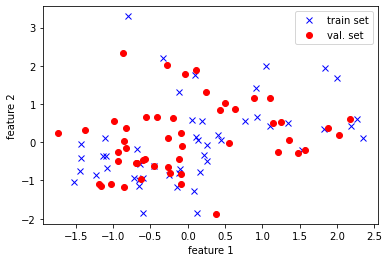

In [ ]:
#전처리 훈련셋, 검증셋으로 산점도 그리기
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bx')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

- 결과를 보면 두 그래프에 미세한 차이가 있다. 이는 훈련셋과 검증셋이 서로 다른 비율로 변환되었다는 증거. 
- 그래서 __검증셋 전처리할 때 훈련셋의 mean, std로 나눠야 함.__

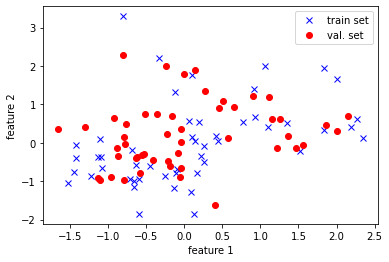

In [ ]:
x_val_scaled = (x_val - train_mean)/train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bx')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

In [ ]:
#다시 성능 측정
layer2.score(x_val_scaled, y_val) #이 데이터에선 큰 변화가 없지만 검증셋 스케일링시 꼭 훈련셋의 정보를 이용해서 하자!!

0.967032967032967

## 05-2. 과대적합과 과소적합
- 여기선 데이터의 수를 더 늘리거나 모델의 복잡도 변화가 어려우므로, 
- 에포크에 따른 손실값의 변화를 그래프로 그려 __적절한 에포크 횟수__를 찾아보자! --> 검증셋(val set)에 대해서만 수행, 새로운 self.val_losses를 추가하고 검증셋을 튜닝하는 `update_val_loss` 메서드 추가 

In [ ]:
import numpy as np
class SingleLayer:

    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = [] #우리가 이전에 만들었던 부분. epoch별 손실값의 변화를 저장(train set의 loss)
        self.val_losses = [] #epoch별 val set의 loss 저장 
        self.w_history= [] 
        self.lr = learning_rate 
    
    # 정방향 계산 메서드(z를 출력)
    def forpass(self, x):
        z = np.sum(x*self.w) + self.b 
        return z

    # 정방향 메서드(a를 출력)
    def activation(self, z):
        a = 1 / (1+np.exp(-z))
        return a 

    # 역방향 계산(그레디언트를 출력)
    def backprop(self, x, err):
        w_grad = x*err
        b_grad = 1*err
        return w_grad, b_grad 

    # 검증셋의 loss값 계산 
    ## 이 과정은 fit메서드가 수행되어 w,b가 실시간으로 바뀌고 있을 떄 같이 넣어줘야 함./또한 val_losses엔 epoch개수만큼 담고 싶은 것이므로
    ## fit의 epoch의 for문에 걸리게끔 이 메서드를 넣어줘야 한다.(왜냐면 모든 업데이트된w ,b값이 아닌 각 epoch끝날 때의 w,b값으로 계산할거니까.)
    def update_val_loss(self, x_val, y_val):
        if x_val is None: #만일 x_val 값이 입력되지 않으면(이후 fit 메서드에서) 그냥 넘긴다.
            return
        val_loss = 0 #train set에서와 동일하게 접근해가면 됨.
        #검증셋의 샘플 각각에 대해 loss 계산 --> 주의!! 어차피 trainset에서 생산된 w,b값만 이용하니까 정방향 계산으로 loss만 뽑아내면 된다.(역방향x)
        for i in range(len(x_val)):
            #정방향 계산
            z = self.forpass(x_val[i])
            a = self.activation(z)
            #loss값 계산
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val))

    # 핵심: 학습 메서드 --> 이 안엔 train셋(x_train, y_train)만 넣기.
    def fit(self, x, y, epochs=100, x_val=None, y_val=None): #(수정) val셋의 loss를 계산하고자 한다면 x_val, y_val에 추가 가능.
        #초기값 설정
        self.w = np.ones(x.shape[1]) 
        self.b = 0
        self.w_history.append(self.w.copy()) #값 초기화 
        np.random.seed(42) #실습 결과 동일함을 위해 설정 
        #epochs만큼 반복
        for i in range(epochs):
            loss = 0 #loss 값 초기화 
            indexes = np.random.permutation(np.arange(len(x))) #index 값 섞기
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z) 
                err = -(y[i]-a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= w_grad*self.lr
                self.b -= b_grad
                #가중치 기록
                self.w_history.append(self.w.copy())
                #각 샘플에 대해 index마다 loss를 계산
                a = np.clip(a, 1e-10, 1-1e-10) 
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a)) 
            self.losses.append(loss/len(y)) 
            self.update_val_loss(x_val, y_val) ## 이 메서드는 epoch의 for문에 걸려야함! 

    # 핵심: 예측 메서드-- 이 안에는 x_test만 넣는다.
    def predict(self, x):
        z = [self.forpass(xi) for xi in x] 
        return np.array(z) >0 
    
    # 평가 메서드-- 이 안에는 앞서 predict로 반환된 값과 y_test를 비교한 정확도를 출력.
    def score(self, x, y):
        return np.mean(self.predict(x) == y)


In [ ]:
#객체
layer3 = SingleLayer()
#훈련
layer3.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)

In [ ]:
#검증셋에 대한 loss값 출력(epoch개수만큼 있음)
print(layer3.val_losses)

[0.08553810839308303, 0.06301966026864922, 0.05823743635136528, 0.056705233565734814, 0.05454343802272435, 0.05343011026990777, 0.04981057499632999, 0.06237488866059179, 0.05324638490075226, 0.060678164919322555, 0.05824905172257171, 0.05543476405438621, 0.06491313104082402, 0.05376623912175823, 0.045997890164433036, 0.06822947135344683, 0.06785269002768003, 0.051343398133601566, 0.05828682624839542, 0.045067043957763106, 0.04865911856120105, 0.05388829947746326, 0.06015996860119463, 0.05079154343140312, 0.05364427744774489, 0.054685794801141656, 0.05173114999547756, 0.06337119186339416, 0.05514504704464367, 0.059718094882982325, 0.06689553557313928, 0.06756771261195332, 0.05599694825530362, 0.05437484069109732, 0.05475526044632921, 0.05382197857415171, 0.06126192484698252, 0.0554723209052547, 0.05833437391531781, 0.062310519977449894, 0.055474538267906486, 0.04944736328636096, 0.05197455973121612, 0.055335077776258575, 0.05150144056259227, 0.07056237316166483, 0.055584197837541184, 0.

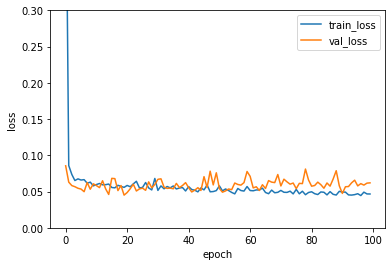

In [ ]:
#위의 결과를 그래프로 표현 
plt.plot(layer3.losses) #훈련셋의 loss
plt.plot(layer3.val_losses) #검증셋의 loss

plt.ylim(0, 0.3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss']) 
plt.show()

- 결과를 보면 train의 loss는 계속해서 줄어드는데 val의 loss는 그렇지 않음을 볼수있다. --> __즉, epoch 20 이후에는 과대적합이 일어나, 가중치 값이 훈련셋에는 잘 맞지만 검증셋에는 잘 맞지 않게 된다.__
- 가장 검증셋의 loss가 작은 지점은 epoch=20일 때이므로, epoch가 20이 되면 훈련을 조기종료하고 이 때의 score을 구해보자.

In [ ]:
#훈련 조기종료하기
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)

In [ ]:
#이 떄의 성능은
layer4.score(x_val_scaled, y_val)

0.978021978021978

## 05-3. L1, L2 규제 
- init에 learning_rate뿐 아니라 l1, l2값도 함께 받음.(여기서의 l1, l2는 각 규제의 하이퍼 파라미터인 alpha 값)
- 실무에서는 규제 효과가 뛰어난 l2규제를 주로 사용함.

In [ ]:
import numpy as np
class SingleLayer:

    def __init__(self, learning_rate=0.1, l1=0, l2=0): #하이퍼파라미터인 alpha 값인 l1, l2값 받음.
        self.w = None
        self.b = None
        self.losses = [] #epoch별 rain set의 loss
        self.val_losses = [] #epoch별 val set의 loss
        self.w_history= [] 
        self.lr = learning_rate 
        self.l1 = l1 #l1규제의 alpha
        self.l2 = l2 #l2규제의 alpha 값 
    
    # 정방향 계산 메서드(z를 출력)
    def forpass(self, x):
        z = np.sum(x*self.w) + self.b 
        return z

    # 정방향 메서드(a를 출력)
    def activation(self, z):
        a = 1 / (1+np.exp(-z))
        return a 

    # 역방향 계산(그레디언트를 출력)
    def backprop(self, x, err):
        w_grad = x*err
        b_grad = 1*err
        return w_grad, b_grad 

    # 로지스틱 손실 함수에 패널티 항 더하기-> fit 메서드에 적용 
    def reg_loss(self):
        return self.l1*np.sum(np.abs(self.w)) + self.l2/2*np.sum(self.w**2)

    # 검증셋의 loss값 계산 
    def update_val_loss(self, x_val, y_val):
        if x_val is None: 
            return
        val_loss = 0 #train set에서와 동일하게 접근해가면 됨.
        #검증셋의 샘플 각각에 대해 loss 계산 --> 주의!! 어차피 trainset에서 생산된 w,b값만 이용하니까 정방향 계산으로 loss만 뽑아내면 된다.(역방향x)
        for i in range(len(x_val)):
            #정방향 계산
            z = self.forpass(x_val[i])
            a = self.activation(z)
            #loss값 계산
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

    # 핵심: 학습 메서드 --> 이 안엔 train셋(x_train, y_train)만 넣기.
    def fit(self, x, y, epochs=100, x_val=None, y_val=None): #(수정) val셋의 loss를 계산하고자 한다면 x_val, y_val에 추가 가능.
        #초기값 설정
        self.w = np.ones(x.shape[1]) 
        self.b = 0
        self.w_history.append(self.w.copy()) #값 초기화 
        np.random.seed(42) #실습 결과 동일함을 위해 설정 
        #epochs만큼 반복
        for i in range(epochs):
            loss = 0 #loss 값 초기화 
            indexes = np.random.permutation(np.arange(len(x))) #index 값 섞기
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z) 
                err = -(y[i]-a)
                w_grad, b_grad = self.backprop(x[i], err)
                #규제 적용
                w_grad += self.l1*np.sign(self.w) +  self.l2*self.w #l1값이 있다면 l1규제, l2값이 있다면 l2 규제 
                #가중치 업데이트 
                self.w -= w_grad*self.lr
                self.b -= b_grad
                #가중치 기록
                self.w_history.append(self.w.copy())
                #각 샘플에 대해 index마다 loss를 계산
                a = np.clip(a, 1e-10, 1-1e-10) 
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a)) 
            self.losses.append(loss/len(y) + self.reg_loss()) #l1, l2 규제 패널티 항 손실함수값에 추가 
            self.update_val_loss(x_val, y_val) 

    # 핵심: 예측 메서드-- 이 안에는 x_test만 넣는다.
    def predict(self, x):
        z = [self.forpass(xi) for xi in x] 
        return np.array(z) >0 
    
    # 평가 메서드-- 이 안에는 앞서 predict로 반환된 값과 y_test를 비교한 정확도를 출력.
    def score(self, x, y):
        return np.mean(self.predict(x) == y)


- cancer 데이터에 __L1 규제__ 적용하기

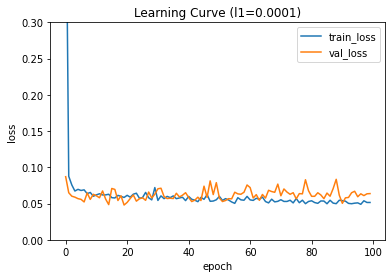

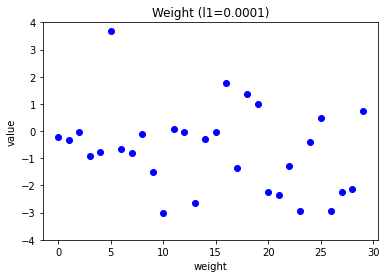

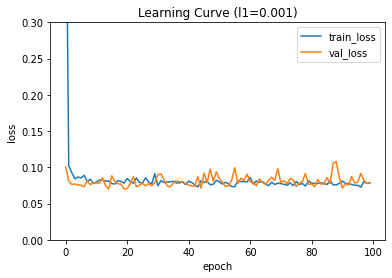

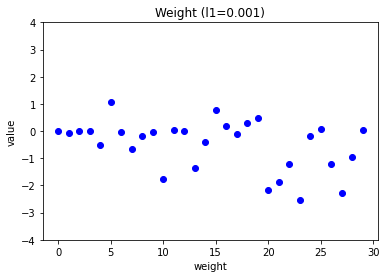

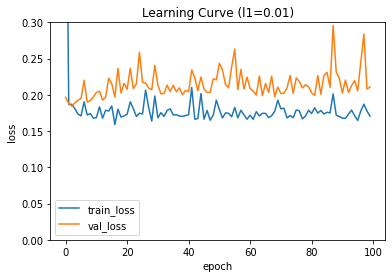

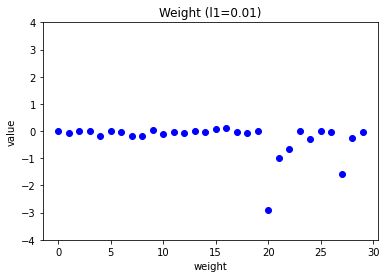

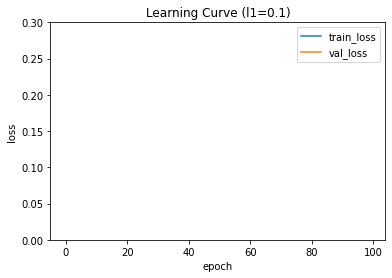

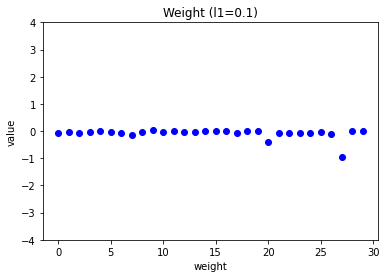

In [ ]:
#l1의 값을 여러개를 해서 성능을 비교해보자.
l1_list = [0.0001, 0.001, 0.01, 0.1]

for l1 in l1_list:
    #객체
    lyr = SingleLayer(l1=l1) #L1만 적용
    #학습
    lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val) #검증셋의 loss도 확인하자.
    #왼쪽 그래프 - L1 값에 따른 훈련셋과 검증셋의 loss 비교 
    plt.plot(lyr.losses) #훈련셋의 loss
    plt.plot(lyr.val_losses) #검증셋의 loss
    plt.title('Learning Curve (l1={0})'.format(l1))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss','val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    #오른쪽 그래프 - L1 값에 따른 가중치(self.w) 값-30개.의 비교
    plt.plot(lyr.w, 'bo') #파랑점으로 self.w 값을 찍음
    plt.title('Weight (l1={0})'.format(l1))
    plt.xlabel('weight')
    plt.ylabel('value')
    plt.ylim(-4,4)
    plt.show()

- l1값(alpha)이 커질수록 규제가 심해진다고 하였다. 그래프를 보면 l1값이 커질수록 성능이 더 안좋아지고(과소적합) 가중치가 0인 것이 많아지고 있다.(사실 규제가 심할수록 복잡도를 낮춰 모델이 더욱 단순해지는 것이므로 보통 규제값을 작게 하는게 일반적임.)
- 여기서 결과를 보면 l1=0.001인 것이 가장 좋아 보이고, epoch=20에서 loss가 가장 낮아진다. 그래서 l1=0.001로 하여 검증셋 성능을 뽑아보자.

In [ ]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

- cancer 데이터에 __L2 규제__ 적용하기

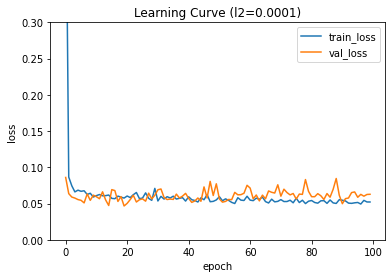

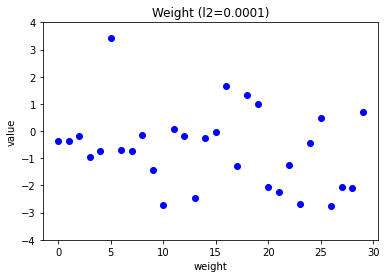

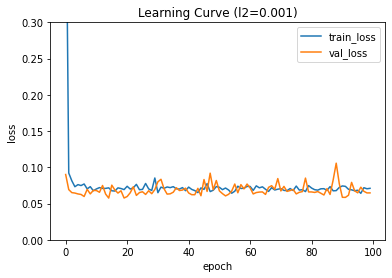

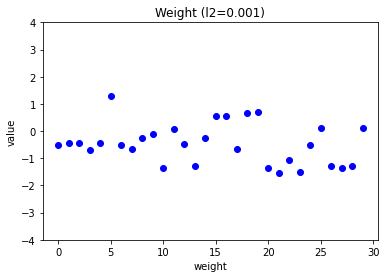

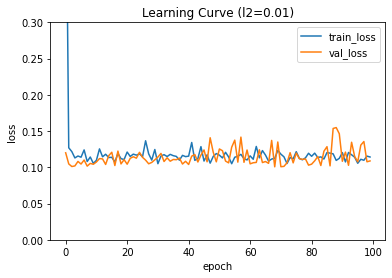

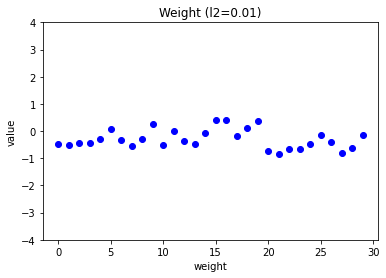

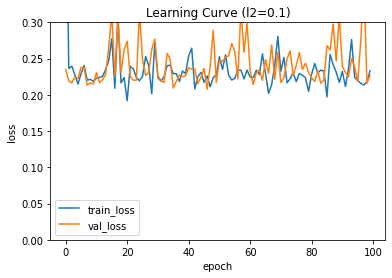

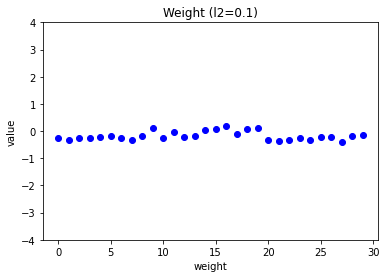

In [ ]:
#l2의 값을 여러개를 해서 성능을 비교해보자.
l2_list = [0.0001, 0.001, 0.01, 0.1]

for l2 in l2_list:
    #객체
    lyr = SingleLayer(l2=l2) #L2만 적용
    #학습
    lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val) #검증셋의 loss도 확인하자.
    #왼쪽 그래프 - L2 값에 따른 훈련셋과 검증셋의 loss 비교 
    plt.plot(lyr.losses) #훈련셋의 loss
    plt.plot(lyr.val_losses) #검증셋의 loss
    plt.title('Learning Curve (l2={0})'.format(l2))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss','val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    #오른쪽 그래프 - L2 값에 따른 가중치(self.w) 값-30개.의 비교
    plt.plot(lyr.w, 'bo') #파랑점으로 self.w 값을 찍음
    plt.title('Weight (l2={0})'.format(l2))
    plt.xlabel('weight')
    plt.ylabel('value')
    plt.ylim(-4,4)
    plt.show()

- l2값(alpha)값이 커짐에 따라 규제가 심해지므로(모델 단순화), L1 규제와 마찬가지의 양상을 보인다. 점차 l2값이 커질수록 과소적합되어 성능이 낮아진다. 다만 가중치(w)값을 보면 아무리 작아지더라도 절대 w를 0으로 만들진 않는다. 
- 또한 l2가 l1보다 성능이 더 좋기 때문에, l2는 규제가 강해져도 l1규제만큼 과소적합이 심해지진 않는다.(왜냐면 l1은 가중치 일부를 아예 0으로 만들어 모델을 단순화하므로 과소적합이 더 심하게 된다. 특히 l2=0.1일 때를 보면 l1은 너무 성능이 안좋아서 그래프 밖에(loss값이 높아 위쪽에) 있는데 l2는 그래도 그래프 안에 그려지긴 한다.)
- 이번엔 l2 =0.001, epoch=20 / l2=0.01, epoch=50을 적용해보자. 

In [ ]:
layer6 = SingleLayer(l2=0.001)
layer6.fit(x_train_scaled, y_train, epochs=20)
layer6.score(x_val_scaled, y_val)

0.978021978021978

In [ ]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.978021978021978

- __이 데이터는 수가 아주 적어서 L1 규제나 L2 규제를 적용한 모델의 성능이 큰 차이가 나지 않는다.__
- 하지만 L2규제일 때 더 최적의 epoch 수가 늘어났고(l1: 20회/ l2: 50회) 규제값도 l2가 더 강하게 규제하였다(l1: 0.001/ l2:0.01). --> _L2의 경우 가중치를 강하게 제한했기 때문에 (가중치값 잘 못바꾸게 함)검증셋의 손실값을 일정한 수준으로 유지하면서 알고리즘이 최적값을 찾는 과정을 오래 반복할 수 있었다._
- 사이킷런의 `SGDClassifier` 클래스도 l1, l2 규제를 지원한다!(하이퍼 파라미터 `alpha` 이용)
- 사이킷런 `LogisticRegression`, `SVC`, `LinearSVC` 들도 l1, l2 규제를 지원한다.(하이퍼 파라미터 `C` 이용, C는 alpha와 반대되는 개념으로 C가 커지면 규제 작아짐.)

In [ ]:
#사이킷런에서 수행하기
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

## 05-4. 교차 검증 for small data
- __교차검증은 검증셋이 훈련셋에 포함됨. 즉, train data 1개를 갖고 k-fold를 하면 되므로 따로 훈련셋, 검증셋을 나눌 필요가 없다!__

In [ ]:
#이번엔 전체 train data인 x_train_all, y_train_all을 입력으로 받아 훈련+검증하자!
#k개의 검증 성능은 validation_scores 리스트에 추가후, 나중에 평균냄. --> 최종 검증성능
validation_scores = []
k = 10
bins = len(x_train_all)//k #폴드 1개의 데이터 수. 만일 개수가 딱 나누어 떨어지지 않는다면 나머지는 그냥 마지막 폴드에 들어감.

for i in range(k): #i는 0부터 시작 
    start = i*bins
    end = (i+1)*bins
    #딱 bins 만큼의 개수만 인덱싱 -> val set으로 임명!
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]

    #남은건 train set으로 임명!
    train_index = list(range(0,start)) + list(range(end, len(x_train_all))) #list끼리 붙이면 하나의 리스트가 됨.(연산자 +)
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]

    ## 스케일링(X에 대해서만 수행, 훈련셋의 정보로 검증셋 나눠주기!) 
    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean)/train_std
    val_fold_scaled = (val_fold - train_mean)/train_std

    #앞에서 만든 클래스 이용하여 학습 & 평가 
    lyr = SingleLayer(l2=0.01) #05-3장에서 최적값이었던 규제를 적용.
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target) #그럼 k번 for문으로 돌리고 있으므로 이것들 k개가 리스트에 담김.
    validation_scores.append(score)

#마지막에는 validation_scores 리스트 안에 담긴 k개의 성능값들을 평균내자.--> 최종 성능값.
print(np.mean(validation_scores))

0.9711111111111113


In [ ]:
print(validation_scores)

[0.9333333333333333, 0.9777777777777777, 0.9555555555555556, 0.9777777777777777, 0.9555555555555556, 1.0, 0.9555555555555556, 1.0, 1.0, 0.9555555555555556]


- 교차검증을 위해서 위의 함수를 구현해도 되지만, 사이킷런에 교차검증 함수가 이미 구현되어 있다!

In [ ]:
#사이킷런 교차검증 수행
from sklearn.model_selection import cross_validate
#객체
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
#교차검증 수행
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10) #train data 전체 넣어버리면 알아서 cv 수행.
print(scores)

{'fit_time': array([0.00538158, 0.00546598, 0.00256157, 0.00290394, 0.00197315,
       0.00278687, 0.00268555, 0.00273705, 0.0026741 , 0.00201392]), 'score_time': array([0.00061965, 0.00044012, 0.00037909, 0.00038123, 0.00037432,
       0.00037599, 0.00039387, 0.0003922 , 0.00039148, 0.0005126 ]), 'test_score': array([0.86956522, 0.93478261, 0.7826087 , 0.95652174, 0.91304348,
       0.75555556, 0.88888889, 0.6       , 0.95555556, 0.84444444])}


In [ ]:
#우리는 scores의 test_score값(val_score)이 k개(10개) 저장돼 있으므로 평균을 내야 최종 성능!
print(np.mean(scores['test_score']))

0.850096618357488


- 어! 왜이렇게 낮지?? --> 우리가 훈련셋, 검증셋으로 나눈 후 __"스케일링"__을 안했기 때문!
- 그런데 직접 코드를 짠게 아니라서 cross_validate 함수 내에서 훈련셋, 검증셋으로 나눈 후 훈련셋의 정보로 스케일링을 하는건 어떻게 하는지 모른다...
- 만일 훈련셋 전체를 전처리하면 나중에 훈련셋 중 일부가 다시 검증셋으로 사용되기 때문에 검증셋 정보가 누설된다ㅠㅠ
#### 방법: 전처리(스케일링) 단계와 모델 클래스 하나로 연결(Pipeline 사용)

In [ ]:
# 전처리(평균, 표준편차 계산)과 SGDClassifier를 pipeline으로 하나로 전달한다.
#그럼 cross_validate은 데이터를 훈련, 검증셋으로 나누기만 하고 그 이후엔 pipeline이 할일(스케일링, 모델링)을 수행함.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler #여기선 스케일링시 standardscaler 이용함
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
pipe = make_pipeline(StandardScaler(), sgd) #pipe안에 표준화, 모델(sgd) 을 전달.
#다시 score 계산
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True) #pipe 객체를 넣어야 한다!!
print(scores)

{'fit_time': array([0.00447655, 0.00440288, 0.00440121, 0.00579715, 0.00393081,
       0.00462818, 0.0051446 , 0.0048964 , 0.00540185, 0.00463915]), 'score_time': array([0.00062752, 0.00060415, 0.00057769, 0.00065494, 0.00060105,
       0.00058913, 0.0006423 , 0.00068164, 0.00069594, 0.00071478]), 'test_score': array([0.93478261, 0.95652174, 1.        , 0.95652174, 0.91304348,
       1.        , 1.        , 1.        , 1.        , 0.93333333]), 'train_score': array([0.99266504, 0.98777506, 0.99022005, 0.98777506, 0.98777506,
       0.98536585, 0.98536585, 0.98780488, 0.98292683, 0.98780488])}


In [ ]:
print(np.mean(scores['test_score'])) #검증셋의 평균성능
print(np.mean(scores['train_score'])) #훈련셋의 평균성능. 사실 얘는 출력할 필요 x. 훈련셋으로 학습한걸 다시 평가하는거니까 높은게 당연함.

0.9694202898550724
0.9875478561631581
